In [1]:
# Hate Xplain

In [2]:
# Import Libraries
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)

import torch
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

c:\Users\cynth\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("LIWC-22 Results - hatexplain - LIWC Analysis.csv")

In [4]:
df.head()

original_text  \
0  i dont think im getting my baby them white 9 h...   
1  we cannot continue calling ourselves feminists...   
2                      nawt yall niggers ignoring me   
3  <user> i am bit confused coz chinese ppl can n...   
4  this bitch in whataburger eating a burger with...   

                                        cleaned_text       label  split  \
0  not think get baby white two white nike not ev...      normal   test   
1  not continue call feminist right womxn not add...      normal  train   
2                                 nawt nigger ignore      normal  train   
3  bit confuse coz chinese people not access twit...  hatespeech  train   
4  bitch whataburger eat burger no top bun hold p...  hatespeech    val   

                  label_distribution  Analytic  Clout  Authentic  Tone  
0                      {'normal': 3}      1.00   1.00      63.35   NaN  
1                      {'normal': 3}     70.33  67.92      24.32   NaN  
2     {'normal': 2, 'hatespeech': 1}      3.80  40.06      63.35   NaN  
3  {'hatespeech': 2, 'offensive': 1}      2.08   1.00      17.84   1.0  
4  {'hatespeech': 2, 'offensive': 1}     80.96   1.00      63.35   1.0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20147 entries, 0 to 20146
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   original_text       20147 non-null  object 
 1   cleaned_text        20147 non-null  object 
 2   label               20147 non-null  object 
 3   split               20147 non-null  object 
 4   label_distribution  20147 non-null  object 
 5   Analytic            19782 non-null  float64
 6   Clout               19284 non-null  float64
 7   Authentic           18032 non-null  float64
 8   Tone                14224 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.4+ MB


In [6]:
def clean_text_gentle(text):
    """
    Gentle preprocessing for SBERT - maintains sentence structure and readability
    while removing only the most problematic elements for hate speech detection.
    Enhanced to handle special symbols, corrupted emojis, and Unicode characters.
    """
    if pd.isna(text):
        return ""
    
    # Convert to string if not already
    text = str(text)
    
    # Remove corrupted/encoded emoji patterns found in the dataset
    corrupted_emoji_patterns = [
        r'ðŸ¤"',  # thinking face
        r'ðŸ˜´',  # sleeping face  
        r'ðŸ¦‹',  # butterfly
        r'ðŸ˜‚',  # laughing crying
        r'ðŸ˜­',  # crying
        r'ðŸ˜',   # heart eyes
        r'ðŸ™„',  # eye roll
        r"ðŸ'€",  # skull
        r'ðŸ˜"',  # disappointed
        r"ðŸ˜'",  # unamused
        r'ðŸ˜',   # neutral face
    ]
    
    # Remove all corrupted emoji patterns
    for pattern in corrupted_emoji_patterns:
        text = re.sub(pattern, ' ', text)
    
    # Remove other corrupted Unicode sequences (ð followed by special chars)
    text = re.sub(r'ð[^\w\s]', ' ', text)
    text = re.sub(r'ð\w[^\w\s]', ' ', text)
    
    # Remove remaining emojis and special Unicode characters
    # Keep basic punctuation and alphanumeric
    text = re.sub(r'[^\w\s\.\,\!\?\;\:\-\(\)\[\]\{\}\'\"@#]', ' ', text)
    
    # Replace HTML entities and tags
    text = re.sub(r'&[a-zA-Z0-9#]+;', ' ', text)  # HTML entities like &amp;
    text = re.sub(r'<[^>]+>', ' ', text)  # HTML tags
    
    # Replace multiple whitespace (including newlines, tabs) with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove excessive punctuation (3+ repeated punctuation marks)
    text = re.sub(r'[.]{3,}', '...', text)  # Keep ellipsis but normalize
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[-]{3,}', '---', text)  # Normalize long dashes
    
    # Clean up quotation marks (convert smart quotes to regular quotes)
    text = text.replace('"', '"').replace('"', '"')  # Left and right double quotes
    text = text.replace(''', "'").replace(''', "'")  # Left and right single quotes
    
    # Remove URLs but preserve the concept of linking
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
                  '[URL]', text)
    
    # Remove anonymization tokens entirely
    text = re.sub(r'<user>', ' ', text)
    text = re.sub(r'<number>', ' ', text)
    text = re.sub(r'<percent>', ' ', text)
    
    # Replace @mentions with generic token (preserves context)
    text = re.sub(r'@[A-Za-z0-9_]+', '[USER]', text)
    
    # Replace hashtags but keep the content
    text = re.sub(r'#([A-Za-z0-9_]+)', r'hashtag \1', text)
    
    # Remove extra spaces around punctuation
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)
    text = re.sub(r'([,.!?;:])\s+', r'\1 ', text)
    
    # Clean up spacing around parentheses and quotes
    text = re.sub(r'\s+([)}\]])', r'\1', text)
    text = re.sub(r'([({[])\s+', r'\1', text)
    
    # Remove excessive capitalization but preserve emphasis
    # Convert ALLCAPS words to Title Case if they're longer than 3 characters
    words = text.split()
    processed_words = []
    for word in words:
        if len(word) > 3 and word.isupper() and word.isalpha():
            processed_words.append(word.capitalize())
        else:
            processed_words.append(word)
    text = ' '.join(processed_words)
    
    # Final cleanup: remove any remaining excessive whitespace
    text = re.sub(r'\s{2,}', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

In [7]:
def clean_text_gentle(text):
    """
    Gentle preprocessing for SBERT - maintains sentence structure and readability
    while removing only the most problematic elements for hate speech detection.
    Enhanced to handle special symbols, corrupted emojis, and Unicode characters.
    """
    if pd.isna(text):
        return ""
    
    # Convert to string if not already
    text = str(text)
    
    # Remove corrupted/encoded emoji patterns found in the dataset
    corrupted_emoji_patterns = [
        r'ðŸ¤"',  # thinking face
        r'ðŸ˜´',  # sleeping face  
        r'ðŸ¦‹',  # butterfly
        r'ðŸ˜‚',  # laughing crying
        r'ðŸ˜­',  # crying
        r'ðŸ˜',   # heart eyes
        r'ðŸ™„',  # eye roll
        r"ðŸ'€",  # skull
        r'ðŸ˜"',  # disappointed
        r"ðŸ˜'",  # unamused
        r'ðŸ˜',   # neutral face
    ]
    
    # Remove all corrupted emoji patterns
    for pattern in corrupted_emoji_patterns:
        text = re.sub(pattern, ' ', text)
    
    # Remove other corrupted Unicode sequences (ð followed by special chars)
    text = re.sub(r'ð[^\w\s]', ' ', text)
    text = re.sub(r'ð\w[^\w\s]', ' ', text)
    
    # Remove remaining emojis and special Unicode characters
    # Keep basic punctuation and alphanumeric
    text = re.sub(r'[^\w\s\.\,\!\?\;\:\-\(\)\[\]\{\}\'\"@#]', ' ', text)
    
    # Replace HTML entities and tags
    text = re.sub(r'&[a-zA-Z0-9#]+;', ' ', text)  # HTML entities like &amp;
    text = re.sub(r'<[^>]+>', ' ', text)  # HTML tags
    
    # Replace multiple whitespace (including newlines, tabs) with single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove excessive punctuation (3+ repeated punctuation marks)
    text = re.sub(r'[.]{3,}', '...', text)  # Keep ellipsis but normalize
    text = re.sub(r'[!]{2,}', '!', text)
    text = re.sub(r'[?]{2,}', '?', text)
    text = re.sub(r'[-]{3,}', '---', text)  # Normalize long dashes
    
    # Clean up quotation marks (convert smart quotes to regular quotes)
    text = text.replace('"', '"').replace('"', '"')  # Left and right double quotes
    text = text.replace(''', "'").replace(''', "'")  # Left and right single quotes
    
    # Remove URLs but preserve the concept of linking
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
                  '[URL]', text)
    
    # Handle anonymization tokens - remove brackets but keep semantic meaning
    text = re.sub(r'<user>', ' ', text)  # Remove user mentions with brackets
    text = re.sub(r'\buser\b', ' ', text)  # Remove standalone "user" tokens
    text = re.sub(r'<date>', 'date', text)  # Keep temporal context
    text = re.sub(r'<number>', 'number', text)  # Keep quantitative context  
    text = re.sub(r'<percent>', 'percent', text)  # Keep percentage context
    text = re.sub(r'<money>', 'money', text)  # Keep financial context
    text = re.sub(r'<time>', 'time', text)  # Keep temporal context
    text = re.sub(r'<url>', 'url', text)  # Keep link context
    
    # Replace @mentions with generic token (preserves context)
    text = re.sub(r'@[A-Za-z0-9_]+', '[USER]', text)
    
    # Replace hashtags but keep the content
    text = re.sub(r'#([A-Za-z0-9_]+)', r'hashtag \1', text)
    
    # Remove extra spaces around punctuation
    text = re.sub(r'\s+([,.!?;:])', r'\1', text)
    text = re.sub(r'([,.!?;:])\s+', r'\1 ', text)
    
    # Clean up spacing around parentheses and quotes
    text = re.sub(r'\s+([)}\]])', r'\1', text)
    text = re.sub(r'([({[])\s+', r'\1', text)
    
    # Remove excessive capitalization but preserve emphasis
    # Convert ALLCAPS words to Title Case if they're longer than 3 characters
    words = text.split()
    processed_words = []
    for word in words:
        if len(word) > 3 and word.isupper() and word.isalpha():
            processed_words.append(word.capitalize())
        else:
            processed_words.append(word)
    text = ' '.join(processed_words)
    
    # Final cleanup: remove any remaining excessive whitespace
    text = re.sub(r'\s{2,}', ' ', text)
    
    # Strip leading/trailing whitespace
    text = text.strip()
    
    return text

In [8]:
# Apply the function to create the new column
df['cleaned_text_gentle'] = df['original_text'].apply(clean_text_gentle)

In [9]:
df

original_text  \
0      i dont think im getting my baby them white 9 h...   
1      we cannot continue calling ourselves feminists...   
2                          nawt yall niggers ignoring me   
3      <user> i am bit confused coz chinese ppl can n...   
4      this bitch in whataburger eating a burger with...   
...                                                  ...   
20142  if ur still on twitter tell carlton i said his...   
20143  when i first got on here and said i hate trump...   
20144  was macht der moslem wenn der zion gegen seine...   
20145  it is awful look at world demographics asians ...   
20146  the jewish globalist elite have only imported ...   

                                            cleaned_text       label  split  \
0      not think get baby white two white nike not ev...      normal   test   
1      not continue call feminist right womxn not add...      normal  train   
2                                     nawt nigger ignore      normal  train   
3      bit confuse coz chinese people not access twit...  hatespeech  train   
4      bitch whataburger eat burger no top bun hold p...  hatespeech    val   
...                                                  ...         ...    ...   
20142  still twitter tell carlton say alcoholic drug ...   offensive    val   
20143  first get say hate trump consider troll people...   offensive  train   
20144  macht der moslem wenn der zion gegen seinen pr...      normal  train   
20145  awful look world demographic asian fuck everyw...  hatespeech  train   
20146  jewish globalist elite import million muslim m...   offensive  train   

                      label_distribution  Analytic  Clout  Authentic  Tone  \
0                          {'normal': 3}      1.00   1.00      63.35   NaN   
1                          {'normal': 3}     70.33  67.92      24.32   NaN   
2         {'normal': 2, 'hatespeech': 1}      3.80  40.06      63.35   NaN   
3      {'hatespeech': 2, 'offensive': 1}      2.08   1.00      17.84   1.0   
4      {'hatespeech': 2, 'offensive': 1}     80.96   1.00      63.35   1.0   
...                                  ...       ...    ...        ...   ...   
20142      {'offensive': 2, 'normal': 1}     49.68  89.50       1.00   1.0   
20143      {'offensive': 2, 'normal': 1}      7.34   1.00      97.09   1.0   
20144      {'offensive': 1, 'normal': 2}     72.44    NaN        NaN   NaN   
20145  {'hatespeech': 2, 'offensive': 1}     16.49   2.18      46.57   1.0   
20146  {'hatespeech': 1, 'offensive': 2}     59.67  66.21      77.17   1.0   

                                     cleaned_text_gentle  
0      i dont think im getting my baby them white 9 h...  
1      we cannot continue calling ourselves feminists...  
2                          nawt yall niggers ignoring me  
3      i am bit confused coz chinese ppl can not acce...  
4      this bitch in whataburger eating a burger with...  
...                                                  ...  
20142  if ur still on twitter tell carlton i said his...  
20143  when i first got on here and said i hate trump...  
20144  was macht der moslem wenn der zion gegen seine...  
20145  it is awful look at world demographics asians ...  
20146  the jewish globalist elite have only imported ...  

[20147 rows x 10 columns]

In [10]:
print(df.isnull().sum())

original_text             0
cleaned_text              0
label                     0
split                     0
label_distribution        0
Analytic                365
Clout                   863
Authentic              2115
Tone                   5923
cleaned_text_gentle       0
dtype: int64


EDA

In [11]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

In [12]:
print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Dataset Info:
Shape: (20147, 10)
Columns: ['original_text', 'cleaned_text', 'label', 'split', 'label_distribution', 'Analytic', 'Clout', 'Authentic', 'Tone', 'cleaned_text_gentle']



Label Distribution:
normal: 8152 (40.5%)
hatespeech: 6234 (30.9%)
offensive: 5761 (28.6%)
Dataset balance: 70.7%


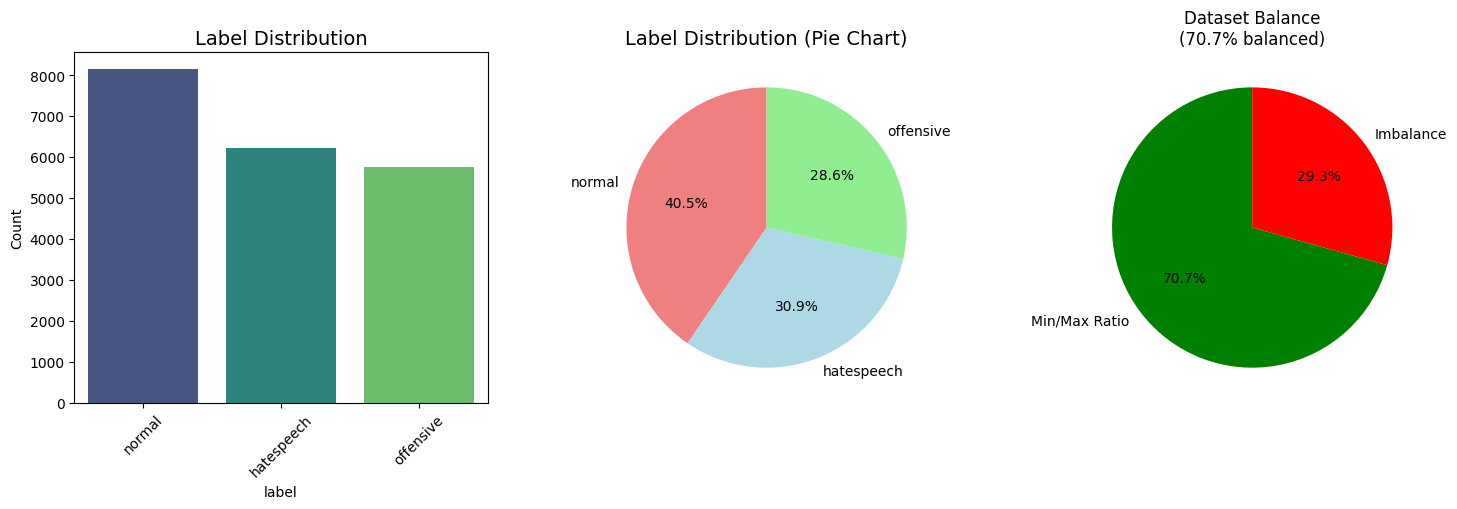

In [13]:
# Label Distribution Analysis
label_counts = df['label'].value_counts()
label_balance = label_counts.min()/label_counts.max()*100

print(f"\nLabel Distribution:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{label}: {count} ({percentage:.1f}%)")

print(f"Dataset balance: {label_balance:.1f}%")

plt.figure(figsize=(15, 5))

# Bar plot
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Label Distribution', fontsize=14)
plt.ylabel('Count')
plt.xticks(rotation=45)

# Pie chart
plt.subplot(1, 3, 2)
colors = ['lightcoral', 'lightblue', 'lightgreen'][:len(label_counts)]
label_counts.plot(kind='pie', autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Label Distribution (Pie Chart)', fontsize=14)
plt.ylabel('')

# Balance visualization
plt.subplot(1, 3, 3)
balance_data = [label_balance, 100-label_balance]
plt.pie(balance_data, labels=['Min/Max Ratio', 'Imbalance'], 
        autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
plt.title(f'Dataset Balance\n({label_balance:.1f}% balanced)', fontsize=12)

plt.tight_layout()
plt.show()


WORD FREQUENCY ANALYSIS
Most Common Words (Overall):
  Word  Frequency
   not       6330
 white       4298
nigger       2830
   get       2190
  like       2182
  fuck       2015
people       1876
 woman       1815
    go       1624
   say       1553
muslim       1549
    no       1522
   jew       1490
retard       1379
 black       1354
 bitch       1322
   one       1175
  want       1157
  kike       1146
  make       1105


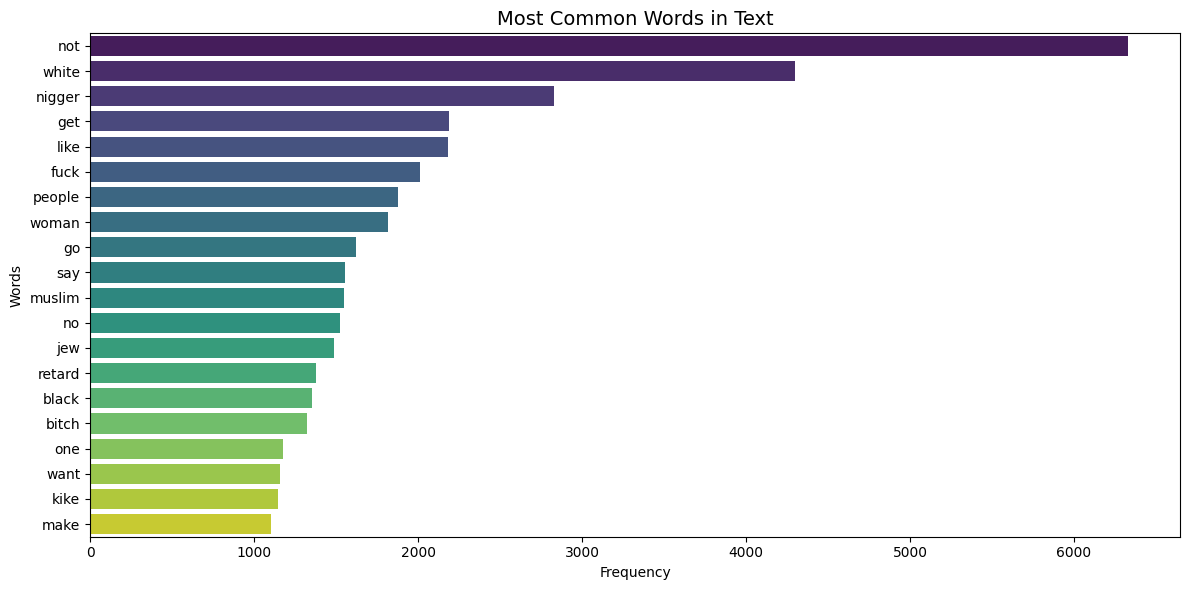

In [14]:
# Most Common Words Analysis
print("\n" + "="*50)
print("WORD FREQUENCY ANALYSIS")
print("="*50)

# Overall most common words
all_text = ' '.join(df['cleaned_text'].dropna())
all_words = all_text.split()
word_freq = Counter(all_words)
top_words_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

print("Most Common Words (Overall):")
print(top_words_df.to_string(index=False))

# Plot most common words
plt.figure(figsize=(12, 6))
sns.barplot(data=top_words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Most Common Words in Text', fontsize=14)
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.tight_layout()
plt.show()


Most common words by label:

NORMAL LABEL - Top 15 words:
 1. not: 2639
 2. white: 2094
 3. people: 952
 4. woman: 904
 5. get: 850
 6. like: 776
 7. say: 734
 8. muslim: 670
 9. go: 592
10. no: 576
11. black: 566
12. fuck: 546
13. immigrant: 488
14. one: 485
15. rap: 478

HATESPEECH LABEL - Top 15 words:
 1. nigger: 2354
 2. not: 1998
 3. white: 1257
 4. kike: 1038
 5. fuck: 891
 6. jew: 812
 7. like: 723
 8. get: 710
 9. go: 559
10. no: 494
11. faggot: 488
12. muslim: 455
13. people: 442
14. say: 430
15. woman: 411

OFFENSIVE LABEL - Top 15 words:
 1. not: 1693
 2. white: 947
 3. retard: 924
 4. like: 683
 5. bitch: 673
 6. get: 630
 7. fuck: 578
 8. ghetto: 506
 9. woman: 500
10. people: 482
11. go: 473
12. no: 452
13. muslim: 424
14. jew: 405
15. say: 389


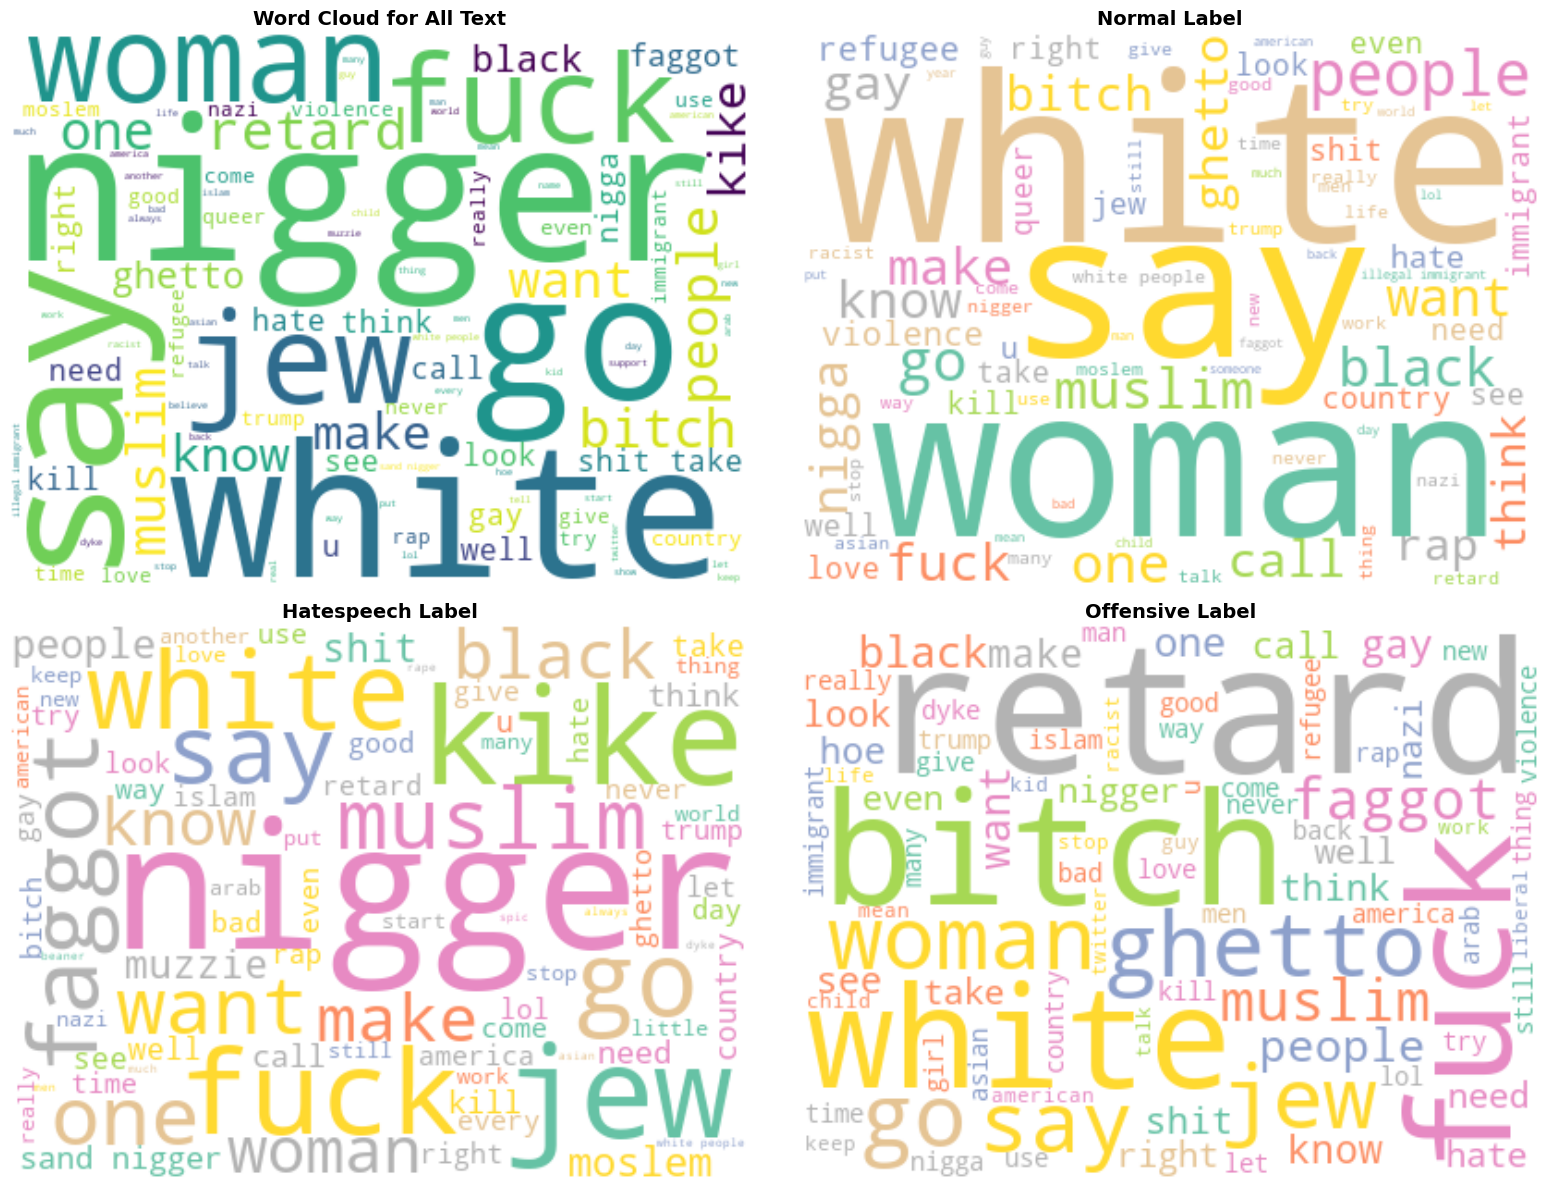

In [15]:
# Most common words by label
print(f"\nMost common words by label:")
for label in df['label'].unique():
    print(f"\n{label.upper()} LABEL - Top 15 words:")
    label_text = ' '.join(df[df['label'] == label]['cleaned_text'].dropna())
    label_words = label_text.split()
    label_freq = Counter(label_words)
    
    for i, (word, count) in enumerate(label_freq.most_common(15), 1):
        print(f"{i:2d}. {word}: {count}")

# Word Clouds
plt.figure(figsize=(16, 12))

# Overall word cloud
plt.subplot(2, 2, 1)
all_text = ' '.join(df['cleaned_text'].dropna())
wordcloud_all = WordCloud(width=400, height=300, background_color='white',
                          max_words=100, colormap='viridis').generate(all_text)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Text', fontsize=14, fontweight='bold')

# Word clouds by label
labels = df['label'].unique()
positions = [2, 3, 4]  # Remaining positions in 2x2 grid

for i, label in enumerate(labels):
    if i < 3:  # Only plot first 3 labels to fit in 2x2 with overall
        plt.subplot(2, 2, positions[i])
        label_text = ' '.join(df[df['label'] == label]['cleaned_text'].dropna())
        
        if len(label_text.strip()) > 0:
            wordcloud = WordCloud(width=400, height=300, background_color='white',
                                 max_words=80, colormap='Set2').generate(label_text)
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'{label.capitalize()} Label', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Feature Engineering

TFIDF-VECTORIZATION

In [16]:
print("Creating TF-IDF Features...")

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    min_df=2,        # Ignore terms that appear in fewer than 3 documents
    max_df=0.85,      # Ignore terms that appear in more than 70% of documents
    max_features=5000,  # Limit to top 5000 features
    stop_words='english',
    lowercase=True,
    ngram_range=(1, 2)  # Include unigrams and bigrams
)

# Fit and transform the cleaned text
tfidf_matrix = tfidf.fit_transform(df['cleaned_text'])
tfidf_feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_feature_names)}")
print(f"First 10 features: {tfidf_feature_names[:10]}")

# Convert to dense array for PCA (use sparse matrix for large datasets)
tfidf_dense = tfidf_matrix.toarray()

Creating TF-IDF Features...
TF-IDF matrix shape: (20147, 5000)
Number of features: 5000
First 10 features: ['2020' 'aa' 'ab' 'abandon' 'ability' 'able' 'abolish' 'abort' 'aborted'
 'abortion']


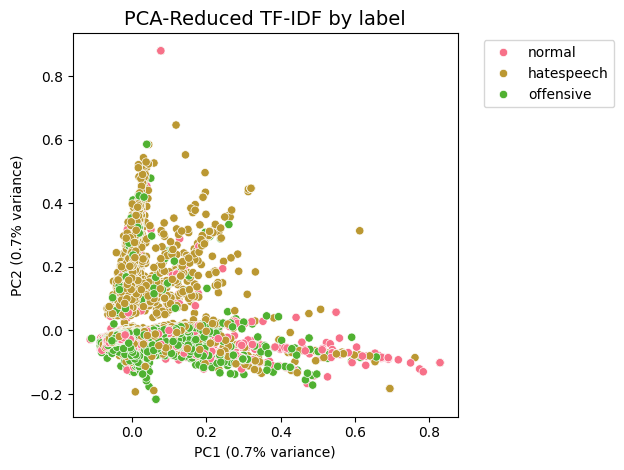

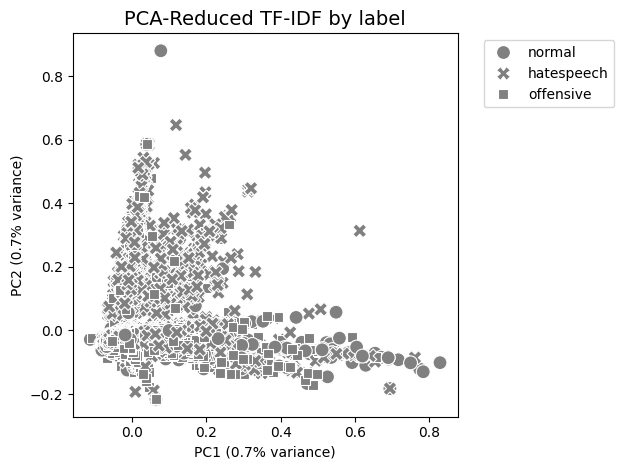

In [24]:
# Reduce matrix to 2D
pca_tfidf = PCA(n_components=2)
tfidf_pca_result = pca_tfidf.fit_transform(tfidf_dense)

# Attach reduced 2D back to original dataframe for future use
df[['tfidf_Dim1','tfidf_Dim2']] = tfidf_pca_result

# Plot with colors
sns.scatterplot(df, x='tfidf_Dim1', y='tfidf_Dim2', hue='label')
plt.title('PCA-Reduced TF-IDF by label', fontsize=14)
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.tight_layout()
plt.show()

# Plot Using different markers instead of colors
sns.scatterplot(df, x='tfidf_Dim1', y='tfidf_Dim2', style='label', hue='label', 
                palette=['gray']*len(df['label'].unique()), s=100)
plt.title('PCA-Reduced TF-IDF by label', fontsize=14)
plt.xlabel(f'PC1 ({pca_tfidf.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_tfidf.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 1)
plt.tight_layout()
plt.show()

LIWC

In [18]:
print("\nPreparing LIWC Features...")

liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']

# Check missing values
print("Missing values in LIWC features:")
for col in liwc_cols:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing} ({(missing/len(df)*100):.1f}%)")


Preparing LIWC Features...
Missing values in LIWC features:
  Analytic: 365 (1.8%)
  Clout: 863 (4.3%)
  Authentic: 2115 (10.5%)
  Tone: 5923 (29.4%)


In [19]:
liwc_features = df[liwc_cols].copy()

# Tone missing = neutral (50)
liwc_features['Tone'] = liwc_features['Tone'].fillna(50) # Technical content lacks emotional tone

# Other features = median
liwc_features = liwc_features.fillna(liwc_features.median()) # Preserves natural data distribution for insufficient text content

LIWC PCA explained variance ratio: [0.33584293 0.25247355]
Total variance explained: 58.8%


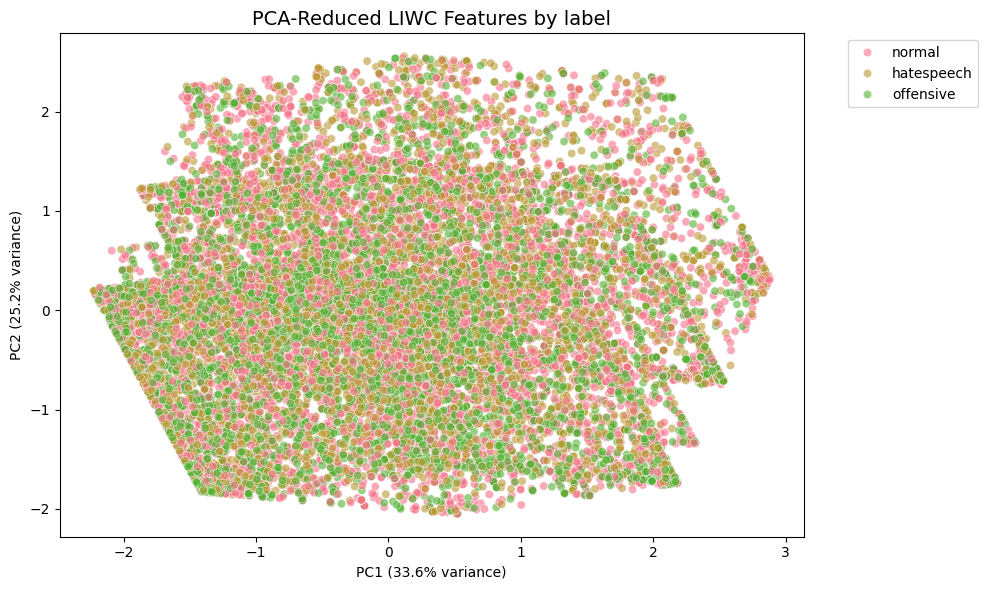

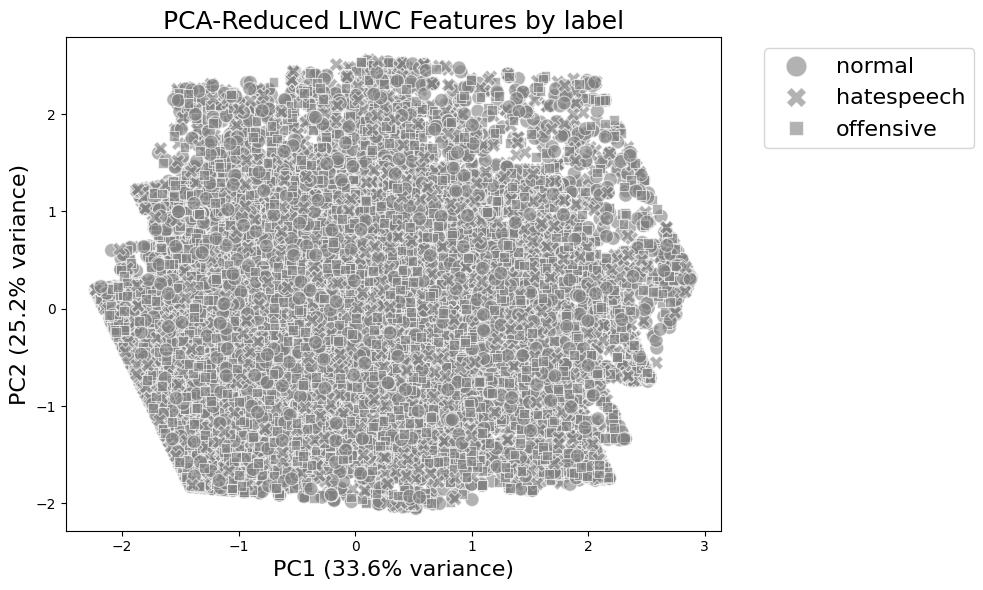

In [33]:
# Standardize LIWC features before PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
liwc_scaled = scaler.fit_transform(liwc_features)

# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA

pca_liwc = PCA(n_components=2, random_state=42)
liwc_pca_result = pca_liwc.fit_transform(liwc_scaled)

# Add PCA results back to dataframe
df[['liwc_Dim1', 'liwc_Dim2']] = liwc_pca_result

print(f"LIWC PCA explained variance ratio: {pca_liwc.explained_variance_ratio_}")
print(f"Total variance explained: {pca_liwc.explained_variance_ratio_.sum():.1%}")

# Visualize PCA results with colors
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='liwc_Dim1', y='liwc_Dim2', hue='label', alpha=0.6)
plt.title('PCA-Reduced LIWC Features by label', fontsize=14)
plt.xlabel(f'PC1 ({pca_liwc.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_liwc.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot using different markers instead of colors
plt.figure(figsize=(10, 6))
sns.scatterplot(df, x='liwc_Dim1', y='liwc_Dim2', style='label', hue='label', 
                palette=['gray']*len(df['label'].unique()), alpha=0.6, s=100)
plt.title('PCA-Reduced LIWC Features by label', fontsize=18)
plt.xlabel(f'PC1 ({pca_liwc.explained_variance_ratio_[0]:.1%} variance)', fontsize=16)
plt.ylabel(f'PC2 ({pca_liwc.explained_variance_ratio_[1]:.1%} variance)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize = 16, markerscale=1.5)
plt.tight_layout()
plt.show()

SBERT

In [21]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
#SBERT
print("Loading Sentence-BERT model...")

# Load pre-trained Sentence-BERT model
# 'all-MiniLM-L6-v2' is fast, lightweight, and high-quality
model = SentenceTransformer('all-MiniLM-L6-v2')

print("Model loaded successfully!")
print(f"Model max sequence length: {model.max_seq_length}")
print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")

# Prepare texts for SBERT
print("Preparing texts...")
texts_for_sbert = df['cleaned_text_gentle'].fillna('').tolist()
print(f"Total texts to process: {len(texts_for_sbert)}")

# Generate SBERT embeddings
print("Generating Sentence-BERT embeddings...")

sbert_embeddings = model.encode(
    texts_for_sbert,
    show_progress_bar=True,
    batch_size=64,  # Can handle larger batches than BERT
    normalize_embeddings=True,
    convert_to_tensor=False,  # Keep as numpy for sklearn compatibility
    output_value='sentence_embedding'  # Explicitly specify output type
)

print(f"SBERT embeddings shape: {sbert_embeddings.shape}")
print(f"Embedding dimension: {sbert_embeddings.shape[1]}")
print("Embeddings generation completed!")

Loading Sentence-BERT model...
Model loaded successfully!
Model max sequence length: 256
Embedding dimension: 384
Preparing texts...
Total texts to process: 20147
Generating Sentence-BERT embeddings...


Batches: 100%|██████████| 315/315 [00:13<00:00, 22.57it/s]

SBERT embeddings shape: (20147, 384)
Embedding dimension: 384
Embeddings generation completed!


Applying PCA for visualization...
SBERT PCA explained variance ratio: [0.04859923 0.03150775]
Total variance explained: 8.0%


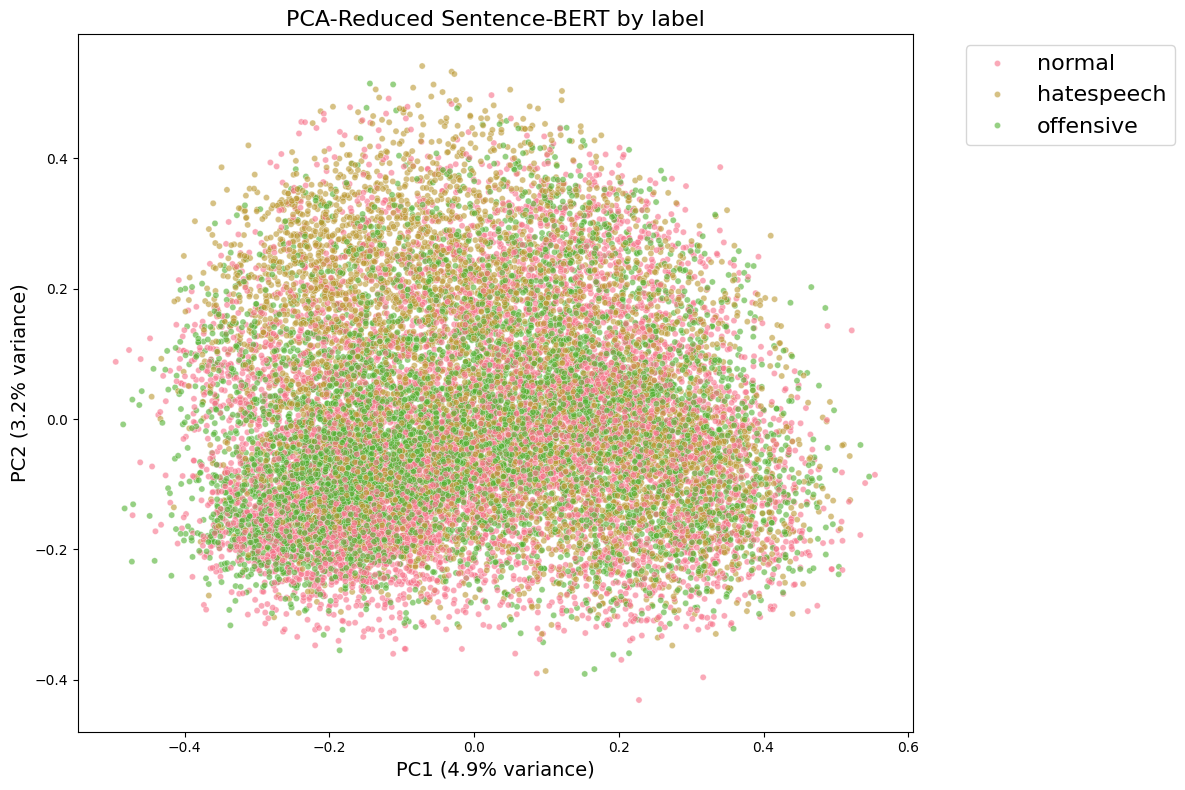

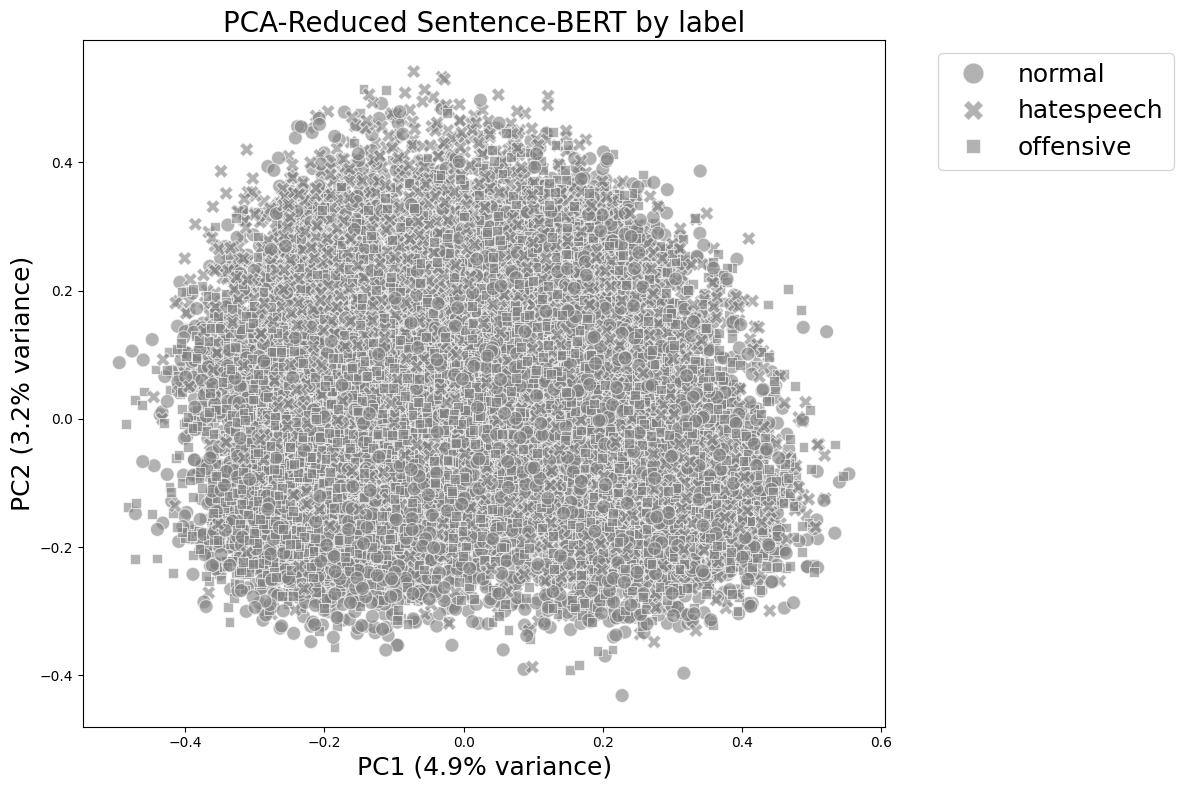

In [35]:
# Apply PCA for visualization
print("Applying PCA for visualization...")
pca_sbert = PCA(n_components=2, random_state=42)
sbert_pca_result = pca_sbert.fit_transform(sbert_embeddings)

# Add PCA results to dataframe
df[['sbert_Dim1', 'sbert_Dim2']] = sbert_pca_result

print(f"SBERT PCA explained variance ratio: {pca_sbert.explained_variance_ratio_}")
print(f"Total variance explained: {pca_sbert.explained_variance_ratio_.sum():.1%}")

# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(df, x='sbert_Dim1', y='sbert_Dim2', hue='label', alpha=0.6, s=20)
plt.title('PCA-Reduced Sentence-BERT by label', fontsize=16)
plt.xlabel(f'PC1 ({pca_sbert.explained_variance_ratio_[0]:.1%} variance)', fontsize=14)
plt.ylabel(f'PC2 ({pca_sbert.explained_variance_ratio_[1]:.1%} variance)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()

# Plot using different markers instead of colors
plt.figure(figsize=(12, 8))
sns.scatterplot(df, x='sbert_Dim1', y='sbert_Dim2', style='label', hue='label',
                palette=['gray']*len(df['label'].unique()), alpha=0.6, s=100)
plt.title('PCA-Reduced Sentence-BERT by label', fontsize=20)
plt.xlabel(f'PC1 ({pca_sbert.explained_variance_ratio_[0]:.1%} variance)', fontsize=18)  
plt.ylabel(f'PC2 ({pca_sbert.explained_variance_ratio_[1]:.1%} variance)', fontsize=18)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=18, markerscale = 1.5)
plt.tight_layout()
plt.show()

Model  Fitting

In [29]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'LinearSVM': LinearSVC(random_state=42, max_iter=2000),
    'Random Forest': RandomForestClassifier(random_state=42),
    
    # Add Hard Vote as LinearSVM doesn't support predict_proba in Soft Vote
    'Hard Voting': VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier(random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000)),
        ('svm', LinearSVC(random_state=42, max_iter=2000)), 
        ('rf', RandomForestClassifier(random_state=42))
    ],
    voting='hard'
    )
}

# Prepare target variable 
y = df['label']  

print(f"Target variable shape: {y.shape}")
print(f"Number of classes: {y.nunique()}")
print(f"Class distribution:\n{y.value_counts()}")

Target variable shape: (20147,)
Number of classes: 3
Class distribution:
label
normal        8152
hatespeech    6234
offensive     5761
Name: count, dtype: int64


In [30]:
# TF-IDF Features 
X_tfidf = tfidf_dense  # TF-IDF matrix
print(f"TF-IDF features shape: {X_tfidf.shape}")

# LIWC Features (standardized)
liwc_cols = ['Analytic', 'Clout', 'Authentic', 'Tone']
X_liwc_raw = liwc_features  # Processed LIWC features
scaler_liwc = StandardScaler()
X_liwc = scaler_liwc.fit_transform(X_liwc_raw)
print(f"LIWC features shape: {X_liwc.shape}")

# SBERT Features
X_sbert = sbert_embeddings  # SBERT embeddings
print(f"SBERT features shape: {X_sbert.shape}")

# Store all feature sets
feature_sets = {
    'TF-IDF': X_tfidf,
    'LIWC': X_liwc,
    'SBERT': X_sbert
}

TF-IDF features shape: (20147, 5000)
LIWC features shape: (20147, 4)
SBERT features shape: (20147, 384)



EVALUATING MODELS WITH TF-IDF FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.556
Precision: 0.558
Recall: 0.556
F1-score: 0.557
CV Score: 0.542 (+/- 0.145)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.63      0.61      0.62      1247
      normal       0.60      0.60      0.60      1631
   offensive       0.42      0.43      0.43      1152

    accuracy                           0.56      4030
   macro avg       0.55      0.55      0.55      4030
weighted avg       0.56      0.56      0.56      4030



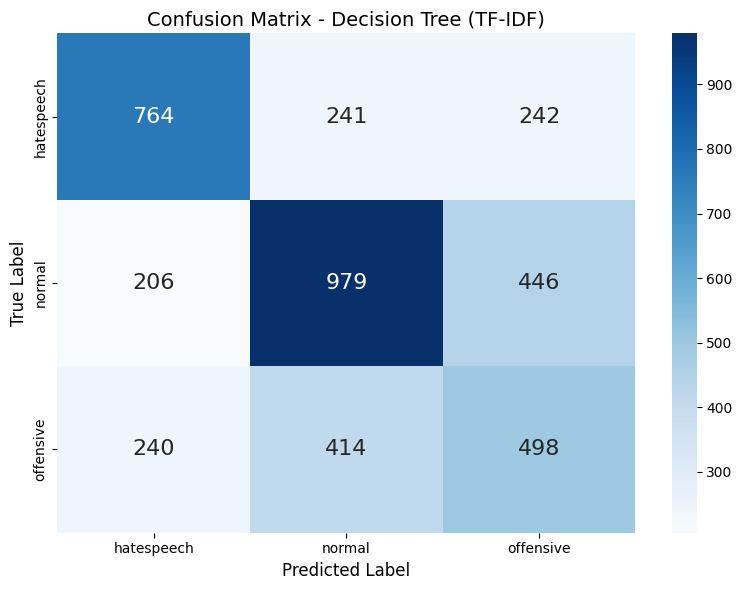


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.628
Precision: 0.622
Recall: 0.628
F1-score: 0.619
CV Score: 0.601 (+/- 0.146)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.71      0.68      0.70      1247
      normal       0.62      0.76      0.68      1631
   offensive       0.53      0.38      0.44      1152

    accuracy                           0.63      4030
   macro avg       0.62      0.61      0.61      4030
weighted avg       0.62      0.63      0.62      4030



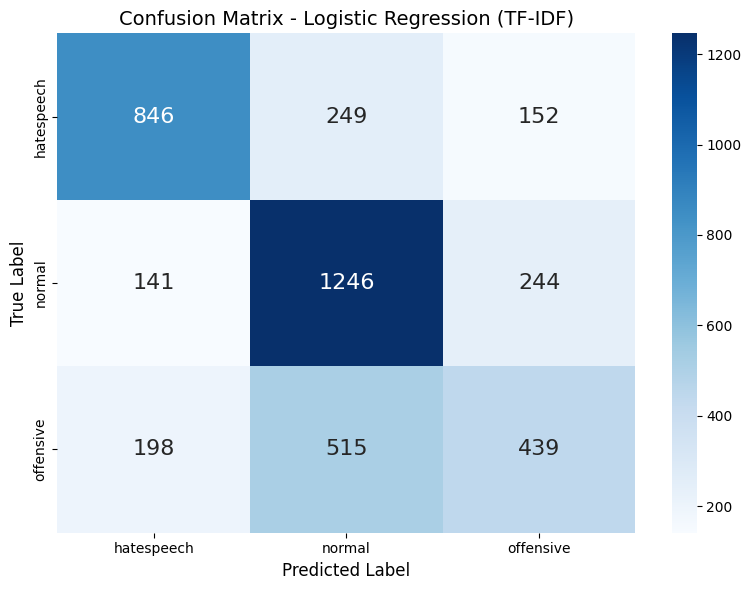


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.592
Precision: 0.586
Recall: 0.592
F1-score: 0.588
CV Score: 0.575 (+/- 0.130)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.66      0.65      0.66      1247
      normal       0.61      0.68      0.65      1631
   offensive       0.47      0.40      0.43      1152

    accuracy                           0.59      4030
   macro avg       0.58      0.58      0.58      4030
weighted avg       0.59      0.59      0.59      4030



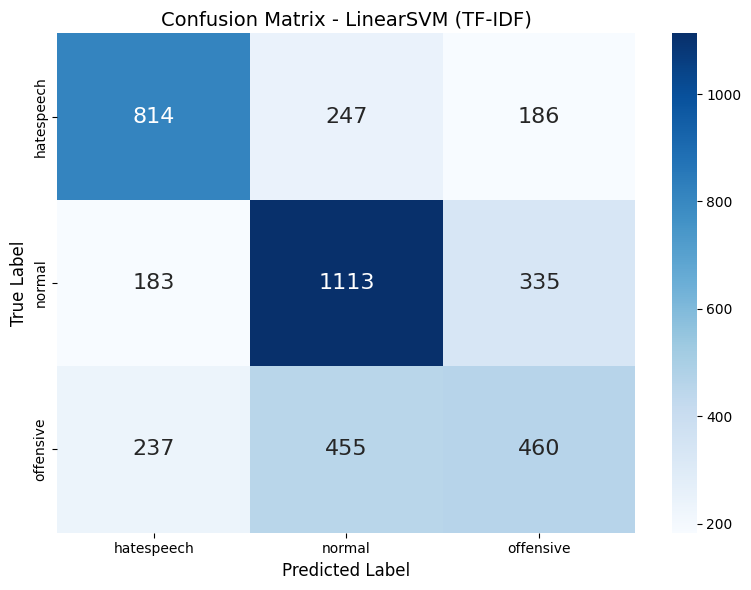


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.632
Precision: 0.631
Recall: 0.632
F1-score: 0.621
CV Score: 0.601 (+/- 0.184)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.74      0.67      0.70      1247
      normal       0.61      0.79      0.69      1631
   offensive       0.55      0.37      0.44      1152

    accuracy                           0.63      4030
   macro avg       0.63      0.61      0.61      4030
weighted avg       0.63      0.63      0.62      4030



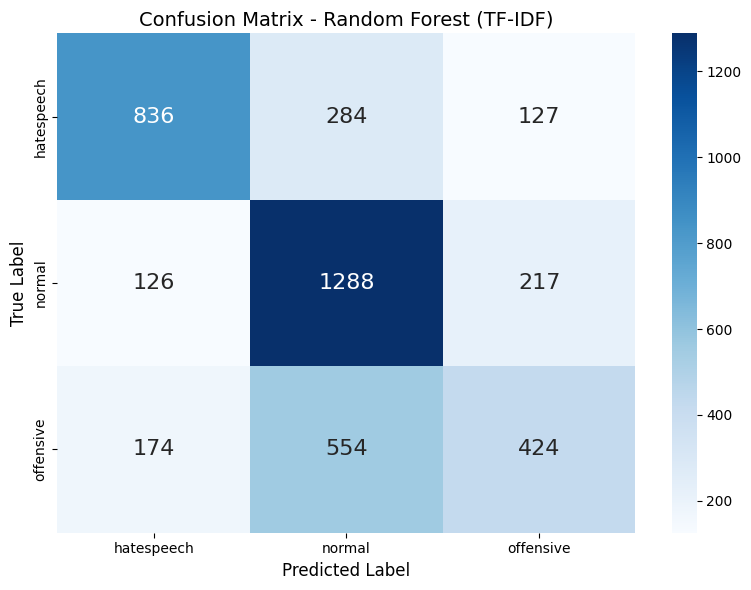


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.631
Precision: 0.624
Recall: 0.631
F1-score: 0.614
CV Score: 0.612 (+/- 0.150)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.69      0.72      0.71      1247
      normal       0.62      0.78      0.69      1631
   offensive       0.57      0.32      0.41      1152

    accuracy                           0.63      4030
   macro avg       0.62      0.61      0.60      4030
weighted avg       0.62      0.63      0.61      4030



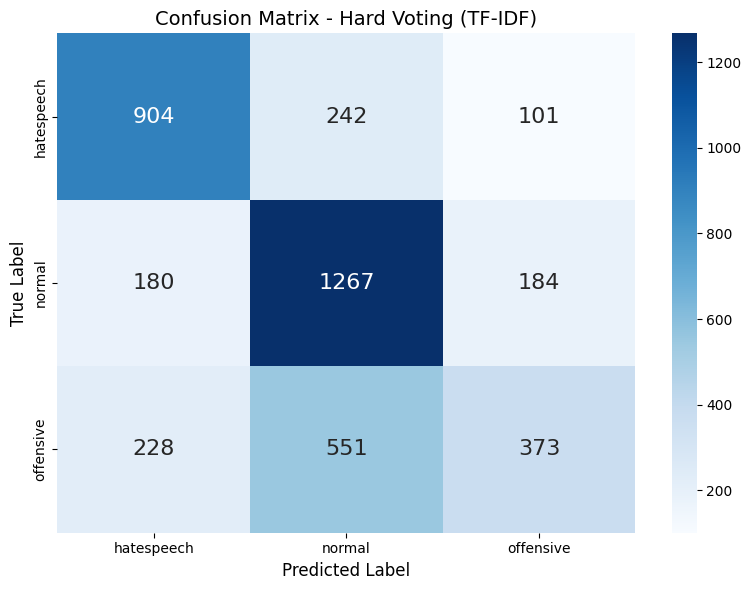

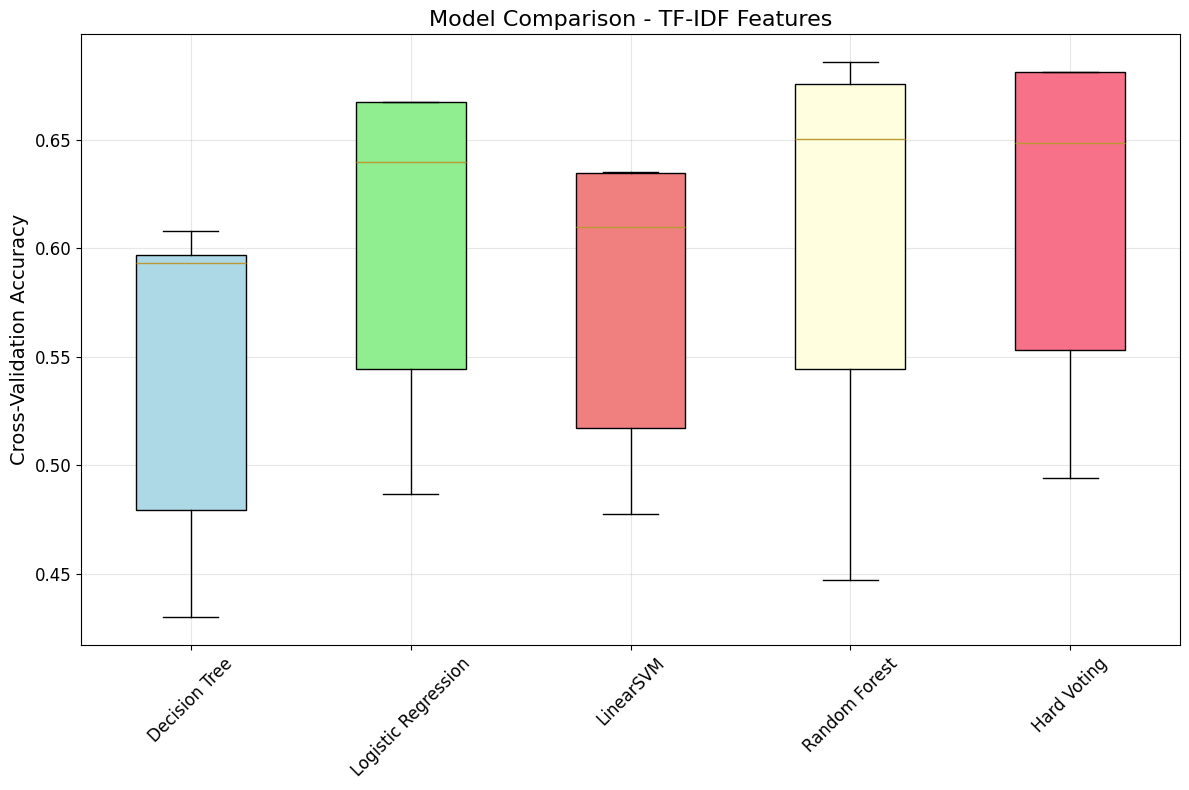


EVALUATING MODELS WITH LIWC FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.365
Precision: 0.364
Recall: 0.365
F1-score: 0.364
CV Score: 0.358 (+/- 0.012)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.33      0.37      0.35      1247
      normal       0.43      0.44      0.43      1631
   offensive       0.30      0.26      0.28      1152

    accuracy                           0.37      4030
   macro avg       0.36      0.36      0.35      4030
weighted avg       0.36      0.37      0.36      4030



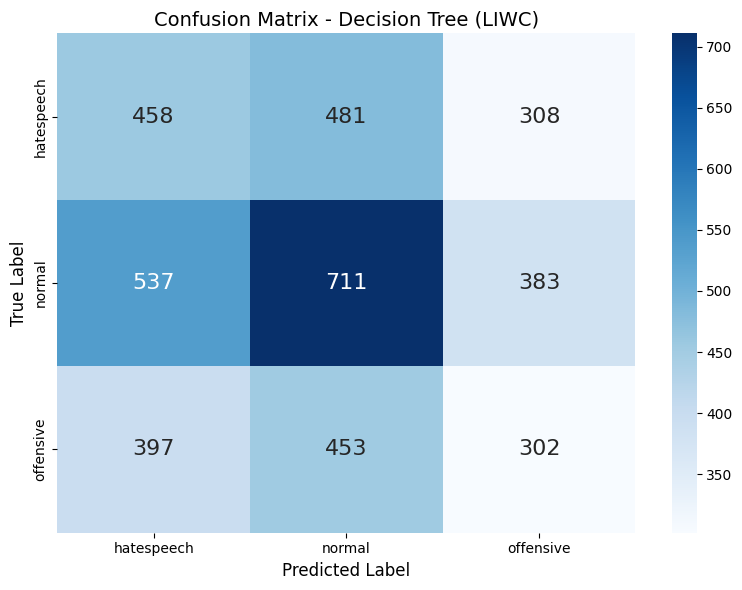


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.428
Precision: 0.301
Recall: 0.428
F1-score: 0.342
CV Score: 0.427 (+/- 0.028)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.40      0.34      0.37      1247
      normal       0.44      0.80      0.56      1631
   offensive       0.00      0.00      0.00      1152

    accuracy                           0.43      4030
   macro avg       0.28      0.38      0.31      4030
weighted avg       0.30      0.43      0.34      4030



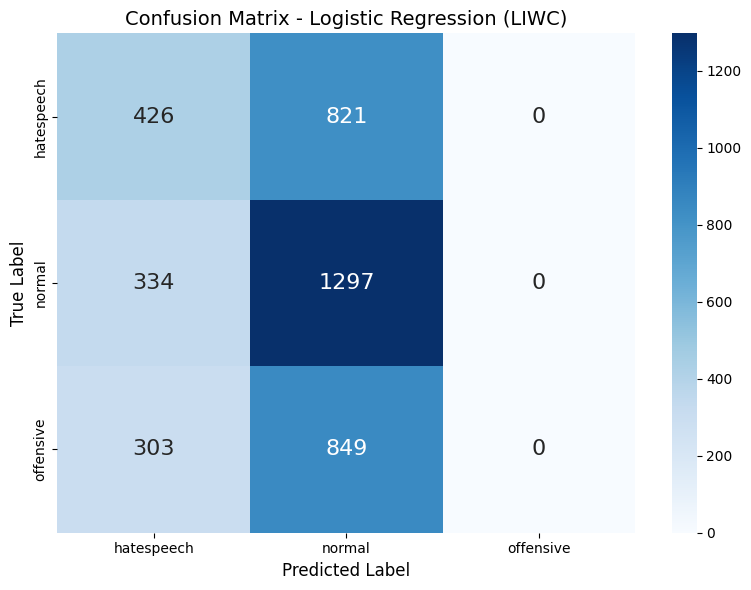


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.428
Precision: 0.301
Recall: 0.428
F1-score: 0.343
CV Score: 0.428 (+/- 0.028)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.40      0.34      0.37      1247
      normal       0.44      0.79      0.56      1631
   offensive       0.00      0.00      0.00      1152

    accuracy                           0.43      4030
   macro avg       0.28      0.38      0.31      4030
weighted avg       0.30      0.43      0.34      4030



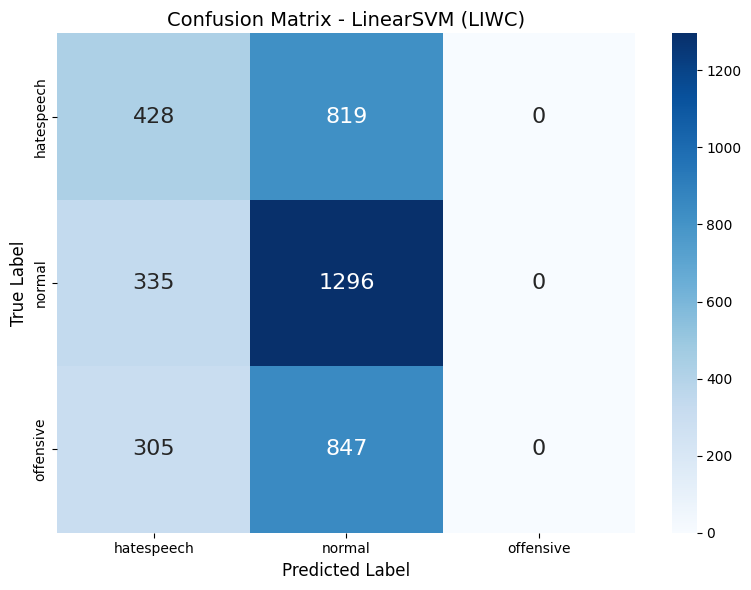


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.361
Precision: 0.353
Recall: 0.361
F1-score: 0.355
CV Score: 0.371 (+/- 0.026)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.33      0.31      0.32      1247
      normal       0.42      0.49      0.45      1631
   offensive       0.29      0.24      0.26      1152

    accuracy                           0.36      4030
   macro avg       0.34      0.34      0.34      4030
weighted avg       0.35      0.36      0.36      4030



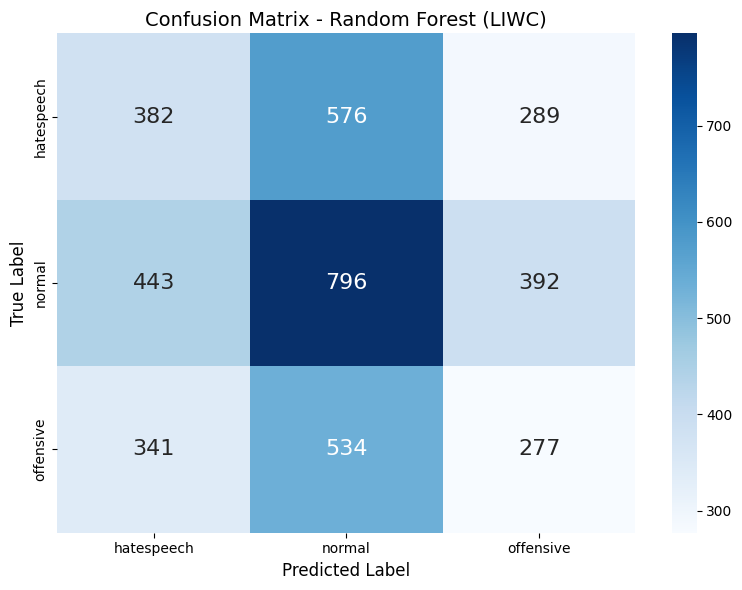


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.409
Precision: 0.480
Recall: 0.409
F1-score: 0.339
CV Score: 0.411 (+/- 0.024)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.36      0.45      0.40      1247
      normal       0.44      0.67      0.53      1631
   offensive       0.67      0.00      0.00      1152

    accuracy                           0.41      4030
   macro avg       0.49      0.37      0.31      4030
weighted avg       0.48      0.41      0.34      4030



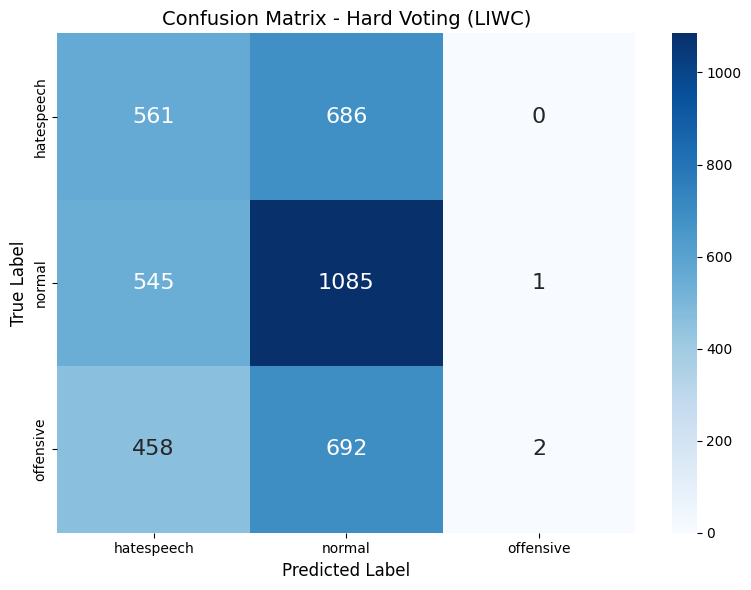

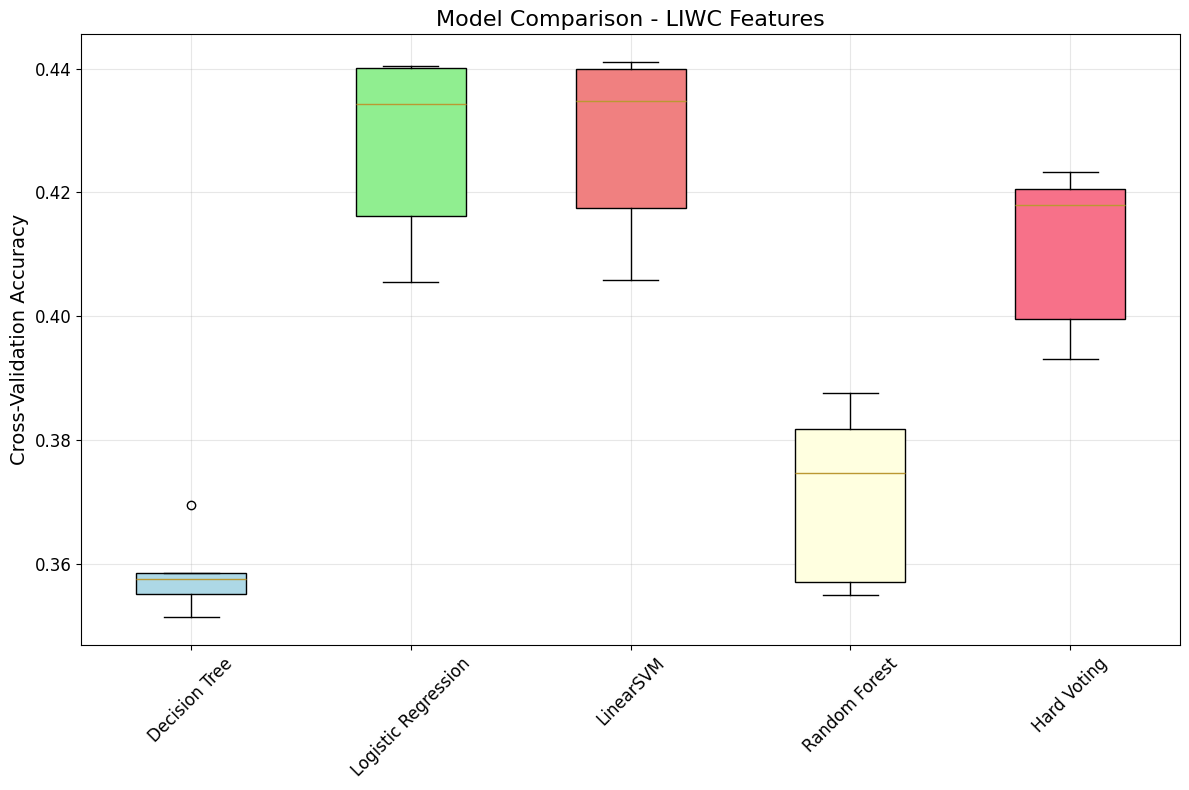


EVALUATING MODELS WITH SBERT FEATURES

Decision Tree Evaluation:
----------------------------------------
Accuracy: 0.440
Precision: 0.439
Recall: 0.440
F1-score: 0.439
CV Score: 0.430 (+/- 0.041)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.47      0.45      0.46      1247
      normal       0.48      0.50      0.49      1631
   offensive       0.35      0.34      0.34      1152

    accuracy                           0.44      4030
   macro avg       0.43      0.43      0.43      4030
weighted avg       0.44      0.44      0.44      4030



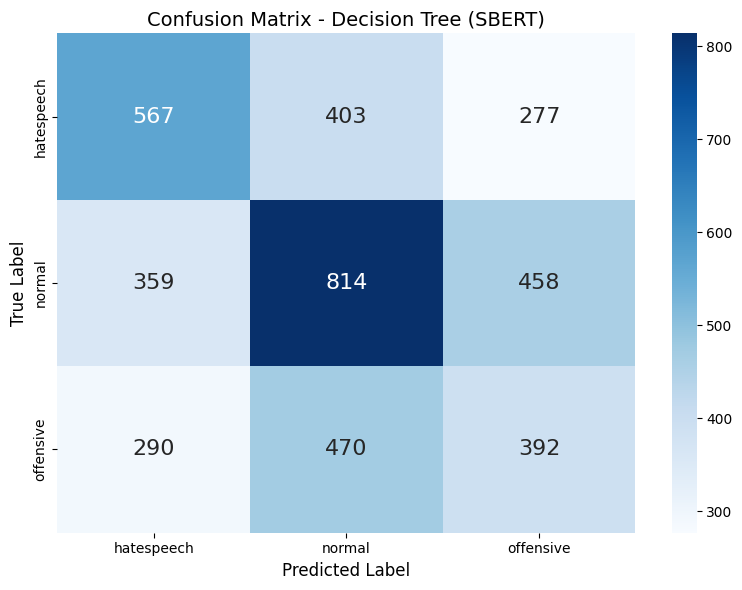


Logistic Regression Evaluation:
----------------------------------------
Accuracy: 0.613
Precision: 0.607
Recall: 0.613
F1-score: 0.604
CV Score: 0.591 (+/- 0.119)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.68      0.66      0.67      1247
      normal       0.61      0.74      0.67      1631
   offensive       0.52      0.37      0.44      1152

    accuracy                           0.61      4030
   macro avg       0.60      0.59      0.59      4030
weighted avg       0.61      0.61      0.60      4030



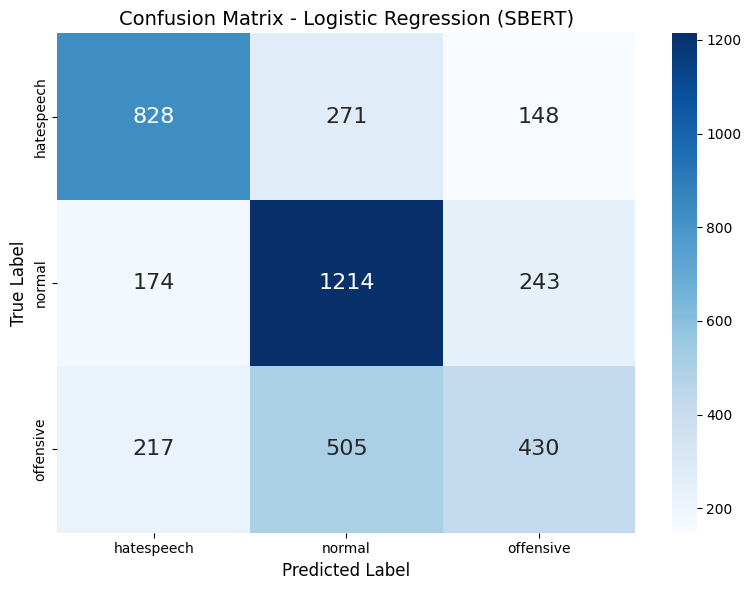


LinearSVM Evaluation:
----------------------------------------
Accuracy: 0.611
Precision: 0.604
Recall: 0.611
F1-score: 0.597
CV Score: 0.590 (+/- 0.121)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.67      0.68      0.67      1247
      normal       0.60      0.75      0.67      1631
   offensive       0.54      0.34      0.41      1152

    accuracy                           0.61      4030
   macro avg       0.60      0.59      0.59      4030
weighted avg       0.60      0.61      0.60      4030



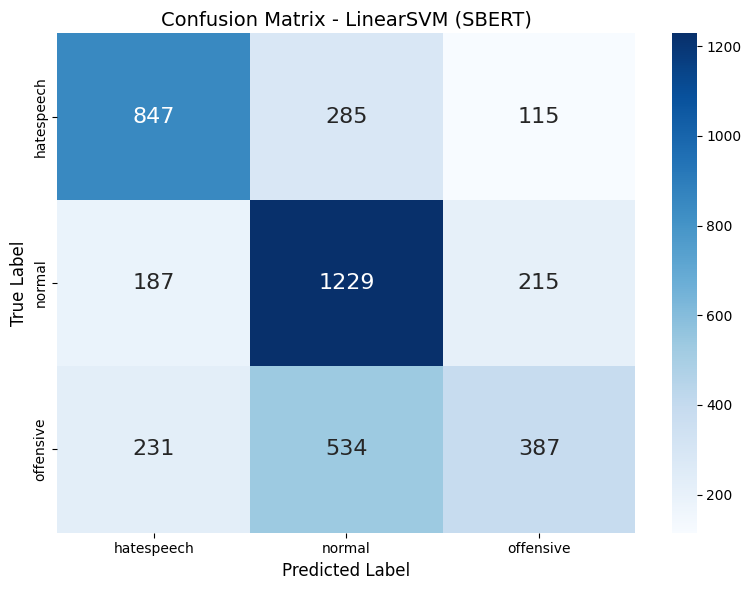


Random Forest Evaluation:
----------------------------------------
Accuracy: 0.579
Precision: 0.594
Recall: 0.579
F1-score: 0.551
CV Score: 0.564 (+/- 0.093)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.69      0.57      0.63      1247
      normal       0.53      0.83      0.65      1631
   offensive       0.57      0.23      0.33      1152

    accuracy                           0.58      4030
   macro avg       0.60      0.54      0.54      4030
weighted avg       0.59      0.58      0.55      4030



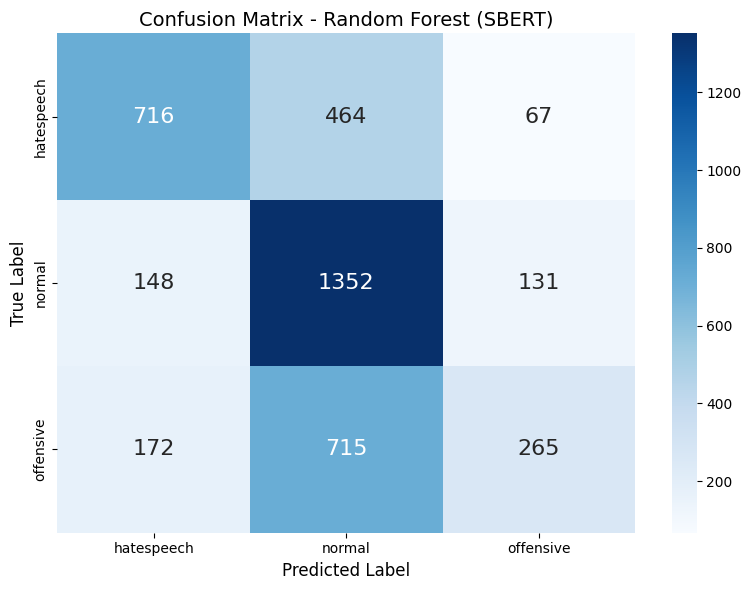


Hard Voting Evaluation:
----------------------------------------
Accuracy: 0.608
Precision: 0.605
Recall: 0.608
F1-score: 0.584
CV Score: 0.591 (+/- 0.103)

Classification Report:
              precision    recall  f1-score   support

  hatespeech       0.67      0.69      0.68      1247
      normal       0.58      0.79      0.67      1631
   offensive       0.57      0.26      0.36      1152

    accuracy                           0.61      4030
   macro avg       0.61      0.58      0.57      4030
weighted avg       0.60      0.61      0.58      4030



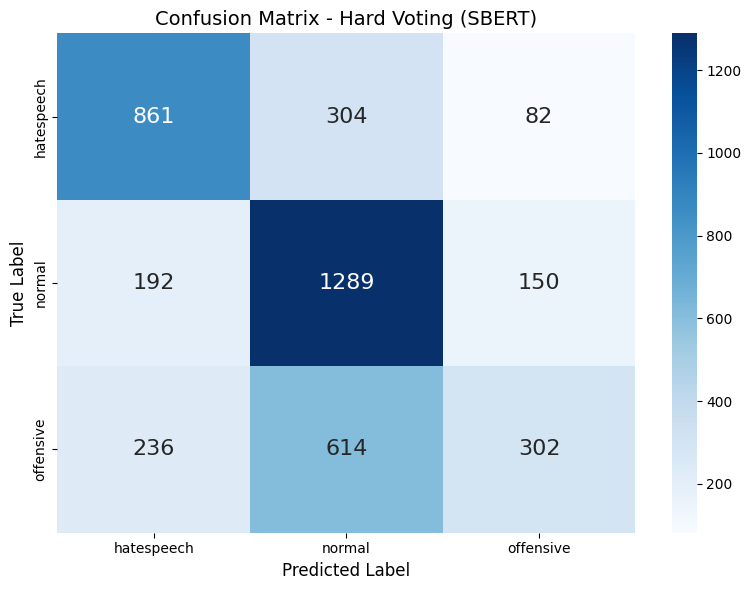

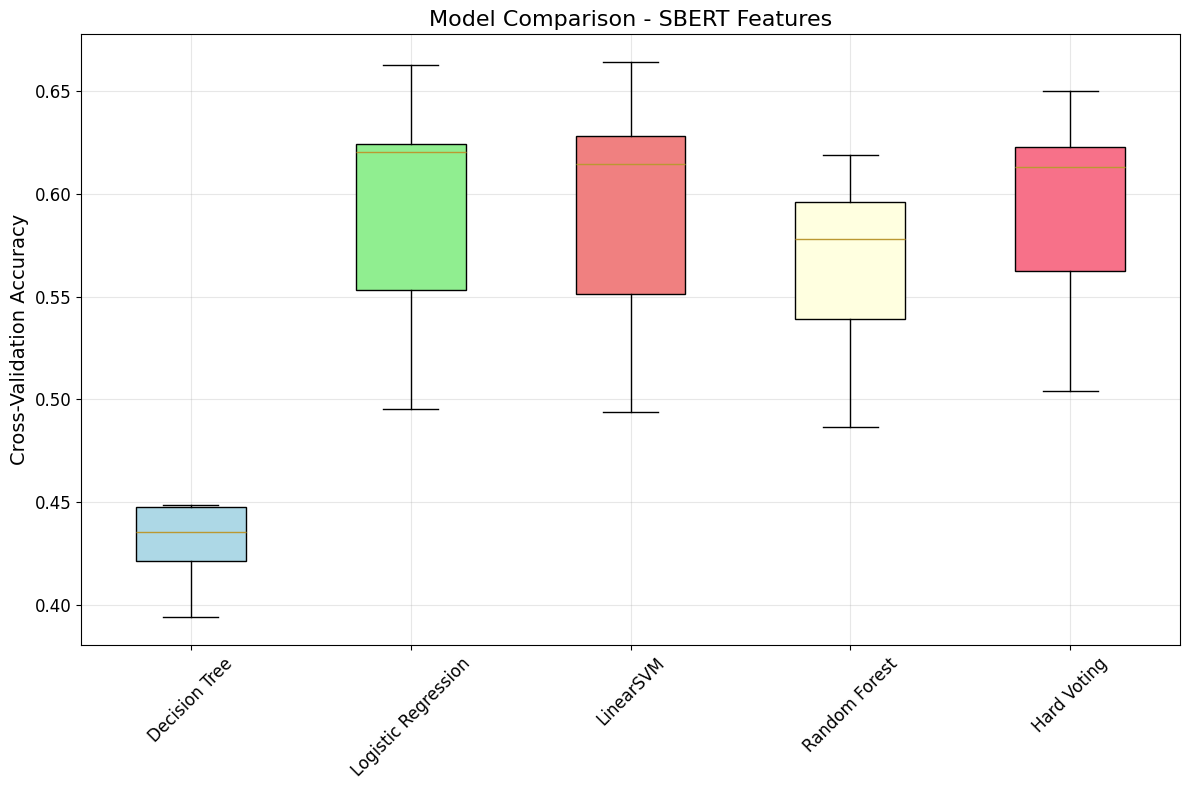

In [31]:
# Initialize dictionary to store all results
all_results = {}

# Iterate through each feature set
for feature_name, X in feature_sets.items():
    print(f"\n{'=' * 60}")
    print(f"EVALUATING MODELS WITH {feature_name.upper()} FEATURES")
    print(f"{'=' * 60}")
    
    # Split data with stratification for balanced classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Store results for this feature set
    feature_results = {}
    
    # Evaluate each model
    for model_name, model in models.items():
        print(f"\n{model_name} Evaluation:")
        print("-" * 40)
        
        # Fit model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate multiple metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted',  zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        
        # Store all metrics
        feature_results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1,
            'CV_Mean': cv_scores.mean(),
            'CV_Std': cv_scores.std(),
            'CV_Scores': cv_scores
        }
        
        # Print results
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-score: {f1:.3f}")
        print(f"CV Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
        
        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(y.unique()),
                    yticklabels=sorted(y.unique()),
                    annot_kws={'size': 16})
        plt.title(f'Confusion Matrix - {model_name} ({feature_name})', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Store results for this feature set
    all_results[feature_name] = feature_results
    
    # Model comparison box plot for this feature set
    plt.figure(figsize=(12, 8))
    cv_scores_list = [feature_results[name]['CV_Scores'] for name in models.keys()]
    bp = plt.boxplot(cv_scores_list, labels=models.keys(), patch_artist=True)
    plt.title(f'Model Comparison - {feature_name} Features', fontsize=16)
    plt.ylabel('Cross-Validation Accuracy', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Color the boxes
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.tight_layout()
    plt.show()

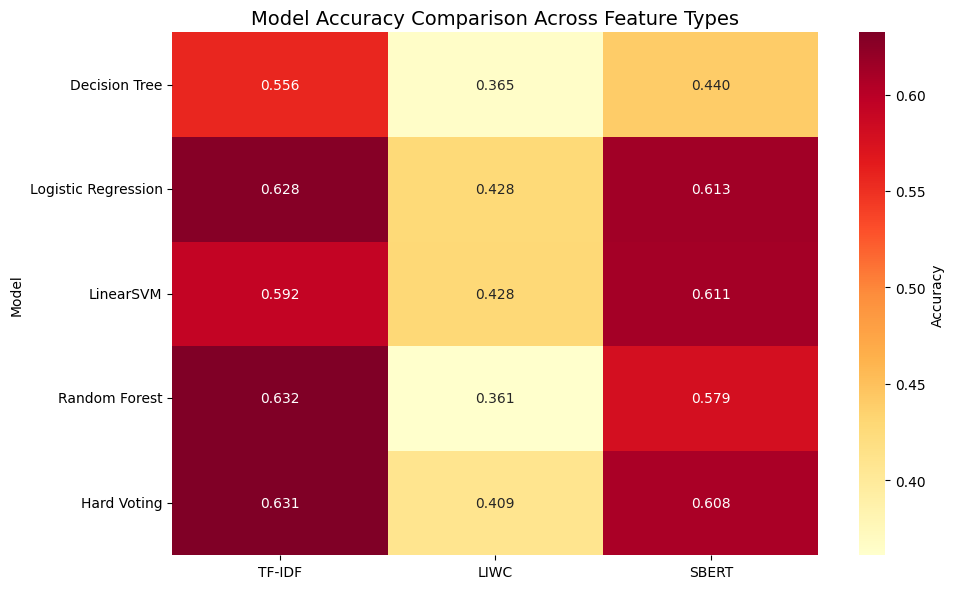

In [58]:
# Accuracy heatmap
accuracy_data = []
for model_name in models.keys():
    row = {'Model': model_name}
    for feature_name in feature_sets.keys():
        row[feature_name] = all_results[feature_name][model_name]['Accuracy']
    accuracy_data.append(row)

accuracy_df = pd.DataFrame(accuracy_data).set_index('Model')

plt.figure(figsize=(10, 6))
sns.heatmap(accuracy_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Accuracy'})
plt.title('Model Accuracy Comparison Across Feature Types', fontsize=14)
plt.tight_layout()
plt.show()

In [57]:
# Print formatted table
print("="*70)
print("MODEL ACCURACY COMPARISON TABLE")
print("="*70)
print(accuracy_df.round(3))

# Print styled table with better formatting
print(f"\n{'='*80}")
print("DETAILED ACCURACY COMPARISON")
print(f"{'='*80}")

# Create a more detailed table with rankings
detailed_table = accuracy_df.round(3).copy()

# Add best model for each feature type (row-wise)
best_per_feature = detailed_table.idxmax(axis=0)
print(f"\nBest model per feature type:")
for feature, best_model in best_per_feature.items():
    best_score = detailed_table.loc[best_model, feature]
    print(f"  {feature:12s}: {best_model:18s} ({best_score:.3f})")

# Add best feature for each model (column-wise)
best_per_model = detailed_table.idxmax(axis=1)
print(f"\nBest feature type per model:")
for model, best_feature in best_per_model.items():
    best_score = detailed_table.loc[model, best_feature]
    print(f"  {model:18s}: {best_feature:12s} ({best_score:.3f})")

# Overall best combination
overall_best = detailed_table.max().max()
best_location = detailed_table.stack().idxmax()
print(f"\nOverall best performance:")
print(f"  {best_location[1]} + {best_location[0]}: {overall_best:.3f}")

# Create performance ranking table
print(f"\n{'='*60}")
print("PERFORMANCE RANKING (Highest to Lowest)")
print(f"{'='*60}")

ranking_data = []
for model in detailed_table.index:
    for feature in detailed_table.columns:
        ranking_data.append({
            'Rank': 0,  # Will be filled after sorting
            'Model': model,
            'Feature': feature,
            'Accuracy': detailed_table.loc[model, feature]
        })

ranking_df = pd.DataFrame(ranking_data)
ranking_df = ranking_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
ranking_df['Rank'] = range(1, len(ranking_df) + 1)

print(ranking_df[['Rank', 'Model', 'Feature', 'Accuracy']].round(3))

MODEL ACCURACY COMPARISON TABLE
                     TF-IDF   LIWC  SBERT
Model                                    
Decision Tree         0.556  0.365  0.440
Logistic Regression   0.628  0.428  0.613
LinearSVM             0.592  0.428  0.611
Random Forest         0.632  0.361  0.579
Hard Voting           0.631  0.409  0.608

DETAILED ACCURACY COMPARISON

Best model per feature type:
  TF-IDF      : Random Forest      (0.632)
  LIWC        : Logistic Regression (0.428)
  SBERT       : Logistic Regression (0.613)

Best feature type per model:
  Decision Tree     : TF-IDF       (0.556)
  Logistic Regression: TF-IDF       (0.628)
  LinearSVM         : SBERT        (0.611)
  Random Forest     : TF-IDF       (0.632)
  Hard Voting       : TF-IDF       (0.631)

Overall best performance:
  TF-IDF + Random Forest: 0.632

PERFORMANCE RANKING (Highest to Lowest)
    Rank                Model Feature  Accuracy
0      1        Random Forest  TF-IDF     0.632
1      2          Hard Voting  TF-IDF    